# Quantum Machine Learning and TTN
Let's look at the Tree Tensor Network as a model for quantum machine learning.

## What you will learn
1. TTN model
2. Optimization

## Install Blueqat

In [2]:
!pip install blueqat

dwave-cloud-client 0.7.2 has requirement click>=7.0, but you'll have click 6.7 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The model we are going to build is called TTN. The quantum circuit is as follows.

<img src="../tutorial-ja/img/253_img.png" width="25%">

It has a shape that takes on tree structure.  
This circuit uses a one qubit arbitrary rotation gate (a combination of $Rz$ and $Ry$ gates) and a two qubit gate ($CX$ gate).  
More details are as follows.

<img src="../tutorial-ja/img/253_img_2.png" width="35%">

In [1]:
from blueqat import Circuit
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

Configure hyperparameters and other settings.

In [41]:
np.random.seed(45)

#最適化計算の回数
nsteps = 2000

#最適化する量子回路のパラメータの数
nparams = 18

#数値微分の細かさ
h = 0.01

#学習率
e = 0.01

#初期のパラメータ
param_init = [np.random.rand()*np.pi*2 for i in range(nparams)]

#結果格納用のlist
arr = []

#1なら訓練、2なら推論
mode = 1

We create a model of the tree structure.  
Set upthe input to the quantum circuit and the target label for it and start learning.  
This time, the input data can be selected by arguments.

In [2]:
def TTN_Z(a, ran, mode=1):
    
    # Input circuit
    init = [Circuit(4).x[0,1], Circuit(4).x[2,3], Circuit(4).x[0], Circuit(4).x[1], Circuit(4).x[2], Circuit(4).x[0,2]]
    # Target label
    target = [1,1,-1,-1,-1,1]
   
    # Circuit construction
    u = init[ran]
    u.rz(a[0])[0].ry(a[1])[0].rz(a[2])[0]
    u.rz(a[3])[1].ry(a[4])[1].rz(a[5])[1]
    u.rz(a[6])[2].ry(a[7])[2].rz(a[8])[2]
    u.rz(a[9])[3].ry(a[10])[3].rz(a[11])[3]
    u.cx[0,1].cx[2,3]
    u.rz(a[12])[1].ry(a[13])[1].rz(a[14])[1]
    u.rz(a[15])[3].ry(a[16])[3].rz(a[17])[3]
    u.cx[1,3]
    
    # Calculate expectation value from state vector
    full = u.run()
    expt = sum(np.abs(full[:8])**2)-sum(np.abs(full[8:])**2)
    
    if(mode ==1):
        # return error between label and prediction
        return (expt - target[ran])**2
    else:
        return expt

Stochastic gradient descent (SGD) is used to learning.
At the start of each step, the input data is randomly selected from 6 ways (0 to 5), and the gradient is calculated and the parameters are updated.

In each step, the gradient calculation and parameter update are performed on only one data, but by repeating the process while randomly selecting input data, the system eventually learns to minimize the loss function for all data.

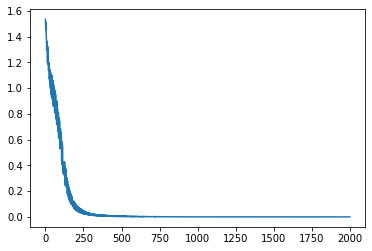

24.156793117523193


In [43]:
start = time.time()

param = param_init.copy()
for i in range(nsteps):
    it = np.random.randint(0,6)
    
    loss = TTN_Z(param, it, mode)
    arr.append(loss)
    param_new = [0 for i in range(nparams)]
    
    for j in range(nparams):
        _param = param.copy()
        _param[j] += h
        param_new[j] = param[j] - e*(TTN_Z(_param, it, mode) - loss)/h

    param = param_new

plt.plot(arr)
plt.show()
print(time.time() - start)

It converged well.  
Let's check it out.

In [45]:
target = [1,1,-1,-1,-1,1]
preds = []
for i in range(6):
    pred = TTN_Z(param, i, mode=2)
    preds.append(pred)
    print("Prediction :", pred, "        Target :", target[i])

Prediction : 0.9884934363107443         Target : 1
Prediction : 0.9842263178153033         Target : 1
Prediction : -0.9884934363107445         Target : -1
Prediction : -0.9862086284188133         Target : -1
Prediction : -0.9842263178153033         Target : -1
Prediction : 0.9865065331709494         Target : 1


From the above, we were able to learn a quantum circuit using the TTN model.